In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

In [2]:
class Load_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.TIF'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
class Preprocess:
    def __call__(self, image):
        sample = np.array(image)
        sample = cv2.normalize(sample, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        processed_image = Image.fromarray(sample).convert('RGB')
        return processed_image

In [4]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/autoencoder_experiment')

2025-01-26 04:55:04.500549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 04:55:04.521443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 04:55:04.527701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 04:55:04.543691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 04:55:05.466899: W tensorflow/compiler/tf2

In [13]:
train_transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((2048, 2048)),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((2048, 2048)),
    transforms.ToTensor()
])

# Load full dataset
full_dataset = Load_data(root_dir='images/normal', transform=transforms.Compose([
    Preprocess(),
    transforms.Resize((2048, 2048)),
    transforms.ToTensor()
]))

# Train/Test Split
train_size = 9
test_size = 2
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Assign separate transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Check sizes
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 9
Test Dataset Size: 2


In [14]:
'''
transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((1024, 1024)),  # Resize to match your input size
    transforms.RandomRotation(degrees=(-30, 30)),  # Random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness/contrast adjustment
    transforms.RandomResizedCrop(size=(1024, 1024), scale=(0.8, 1.0)),  # Random cropping
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for stability
])

dataset = Load_data(root_dir='images/normal', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
'''
pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 56x56 -> 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),    # 112x112 -> 224x224
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

In [6]:
dummy_input = torch.randn(1, 3, 1024, 1024).to(device)
writer.add_graph(autoencoder.module, dummy_input)

In [26]:
def log_latent_space(model, dataloader, writer, tag):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sample_img = next(iter(dataloader))  # Get the first batch
        sample_img = sample_img.to(device)

        # Get latent space (encoder output)
        latent_space = model.module.encoder(sample_img)  # Use `.module.encoder` if DataParallel is used

        # Debugging: Check shape
        print(f"Latent space shape: {latent_space.shape}, dtype: {latent_space.dtype}")

        # Select the first 8 channels and the first image in the batch
        latent_space = latent_space[0:1, :8, :, :]  # Shape [1, 8, 64, 64]

        # Normalize and convert to CPU
        latent_space = latent_space.permute(1, 0, 2, 3).float().cpu()  # Convert to [N, C, H, W]
        
        # Log latent space to TensorBoard
        latent_grid = make_grid(latent_space, normalize=True, scale_each=True)
        writer.add_image(f'Latent Space/{tag}', latent_grid)


In [15]:
from torchvision.utils import make_grid

#log_latent_space(autoencoder, dataloader, writer, tag='Before Training')

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    autoencoder.train()

    for i, img in enumerate(train_loader):
        img = img.to(device)

        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

    train_loss /= len(train_loader.dataset)
    #writer.add_scalar('Loss/train', train_loss, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

# Log latent space after training
#log_latent_space(autoencoder, dataloader, writer, tag='After Training')

# Close the TensorBoard writer
#writer.close()

Epoch [1/100], Train Loss: 0.0293
Epoch [2/100], Train Loss: 0.0291
Epoch [3/100], Train Loss: 0.0286
Epoch [4/100], Train Loss: 0.0262
Epoch [5/100], Train Loss: 0.0180
Epoch [6/100], Train Loss: 0.0142
Epoch [7/100], Train Loss: 0.0093
Epoch [8/100], Train Loss: 0.0074
Epoch [9/100], Train Loss: 0.0098
Epoch [10/100], Train Loss: 0.0076
Epoch [11/100], Train Loss: 0.0097
Epoch [12/100], Train Loss: 0.0061
Epoch [13/100], Train Loss: 0.0078
Epoch [14/100], Train Loss: 0.0054
Epoch [15/100], Train Loss: 0.0055
Epoch [16/100], Train Loss: 0.0048
Epoch [17/100], Train Loss: 0.0038
Epoch [18/100], Train Loss: 0.0025
Epoch [19/100], Train Loss: 0.0023
Epoch [20/100], Train Loss: 0.0022
Epoch [21/100], Train Loss: 0.0022
Epoch [22/100], Train Loss: 0.0023
Epoch [23/100], Train Loss: 0.0026
Epoch [24/100], Train Loss: 0.0029
Epoch [25/100], Train Loss: 0.0030
Epoch [26/100], Train Loss: 0.0021
Epoch [27/100], Train Loss: 0.0029
Epoch [28/100], Train Loss: 0.0031
Epoch [29/100], Train Loss: 0

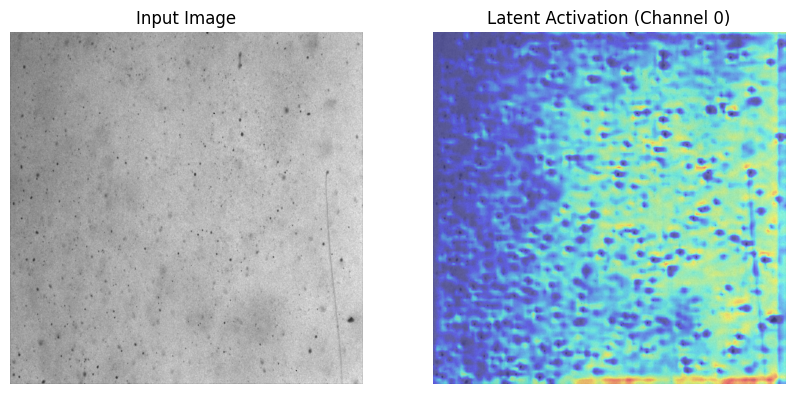

In [16]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

def visualize_latent_with_input(model, dataloader, channel=0):
    model.eval()
    with torch.no_grad():
        # Get a sample image and its latent space
        sample_img = next(iter(dataloader))
        sample_img = sample_img.to(device)
        latent_space = model.module.encoder(sample_img)  # Get latent space

        # Select one channel and move it to CPU
        latent_activation = latent_space[0, channel, :, :].cpu()  # First image, specified channel

        # Normalize the activation for better visualization
        latent_activation -= latent_activation.min()
        latent_activation /= latent_activation.max()

        # Resize the activation to match the input size
        resized_activation = resize(latent_activation.unsqueeze(0), sample_img.shape[-2:])

        # Convert the input image to a CPU numpy array for visualization
        input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()

        # Plot the input and overlay the activation
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(input_img, alpha=0.7)
        plt.imshow(resized_activation.squeeze(), cmap="jet", alpha=0.5)
        plt.title(f"Latent Activation (Channel {channel})")
        plt.axis("off")
        plt.show()

# Visualize the latent space activation for a specific channel
visualize_latent_with_input(autoencoder, test_loader, channel=0)

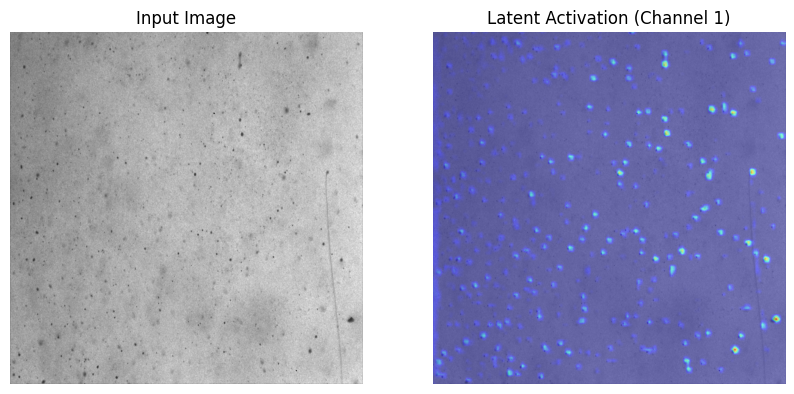

In [17]:
visualize_latent_with_input(autoencoder, test_loader, channel=1)

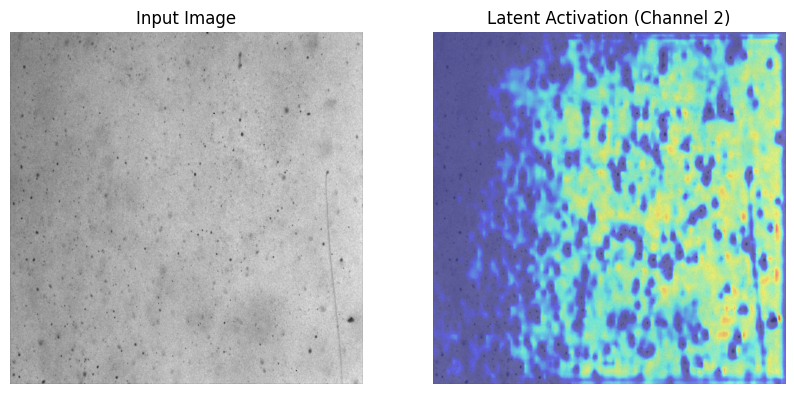

In [18]:
visualize_latent_with_input(autoencoder, test_loader, channel=2)

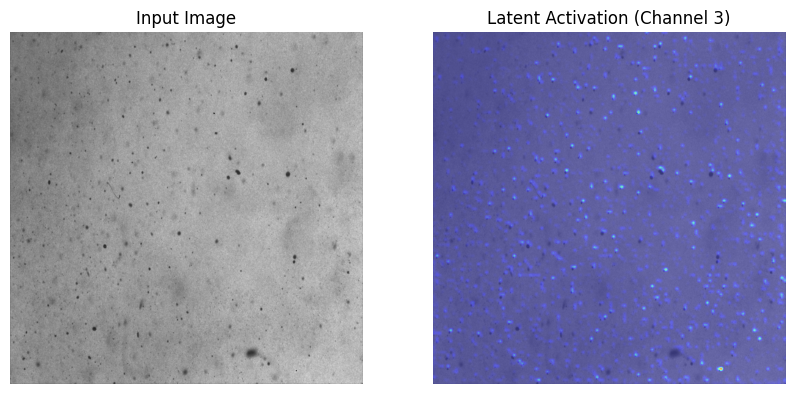

In [10]:
visualize_latent_with_input(autoencoder, test_loader, channel=3)

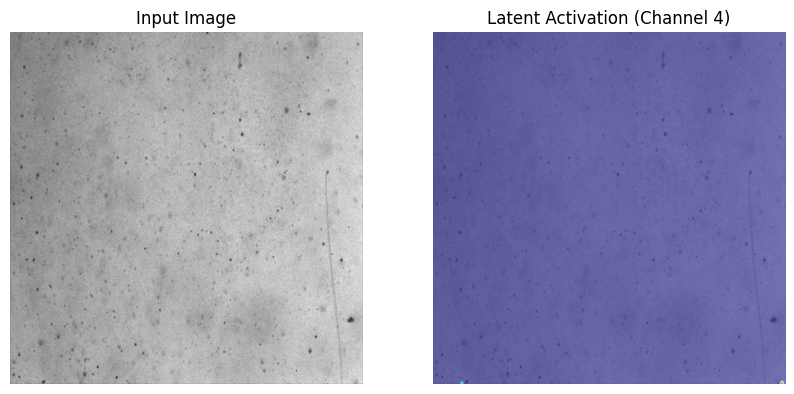

In [19]:
visualize_latent_with_input(autoencoder, test_loader, channel=4)

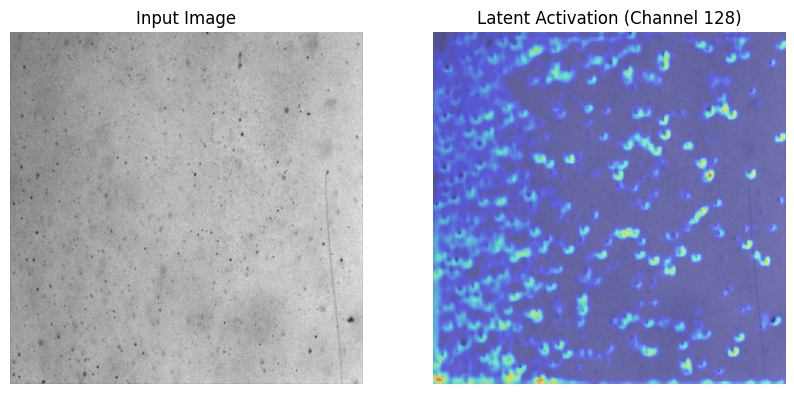

In [20]:
visualize_latent_with_input(autoencoder, test_loader, channel=128)

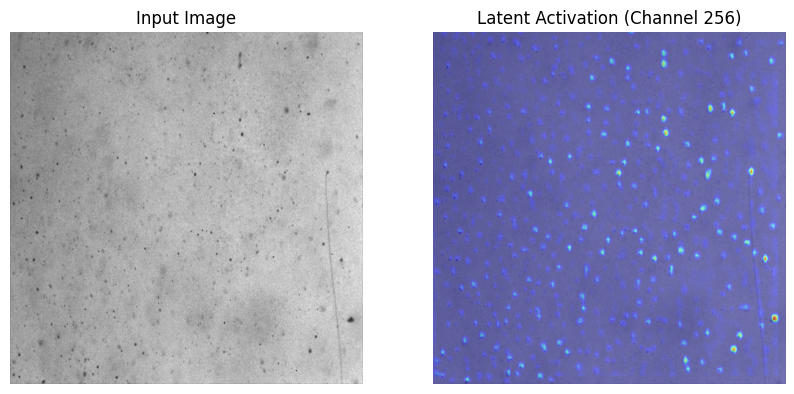

In [21]:
visualize_latent_with_input(autoencoder, test_loader, channel=256)

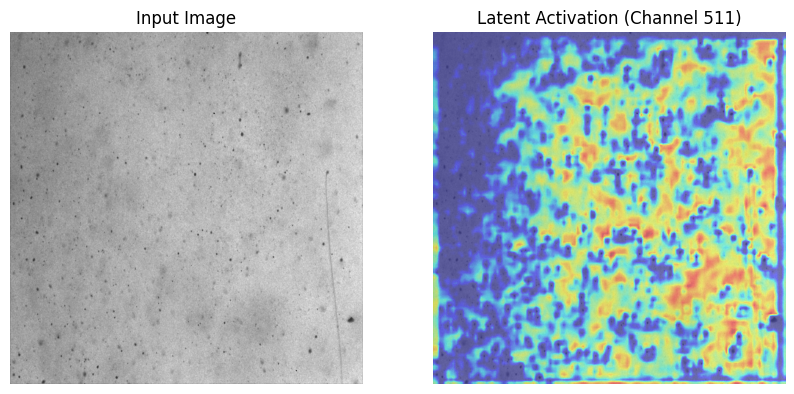

In [22]:
visualize_latent_with_input(autoencoder, test_loader, channel=511)

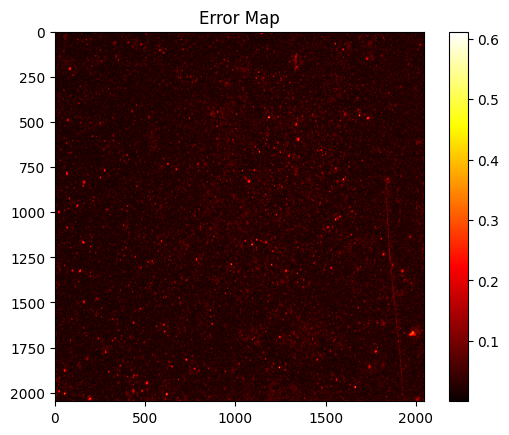

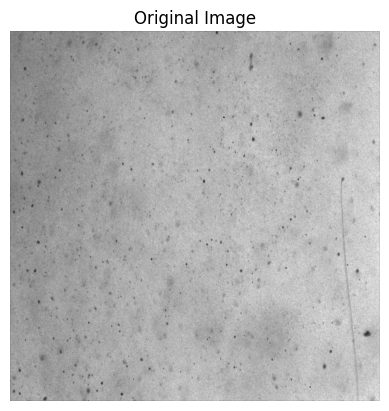

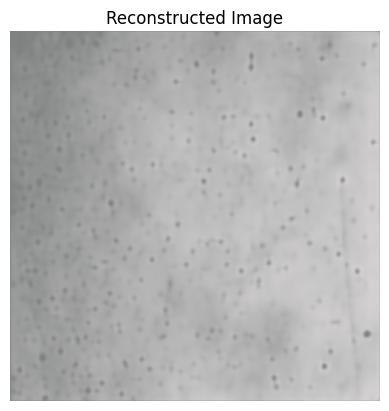

In [23]:
sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0]
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")

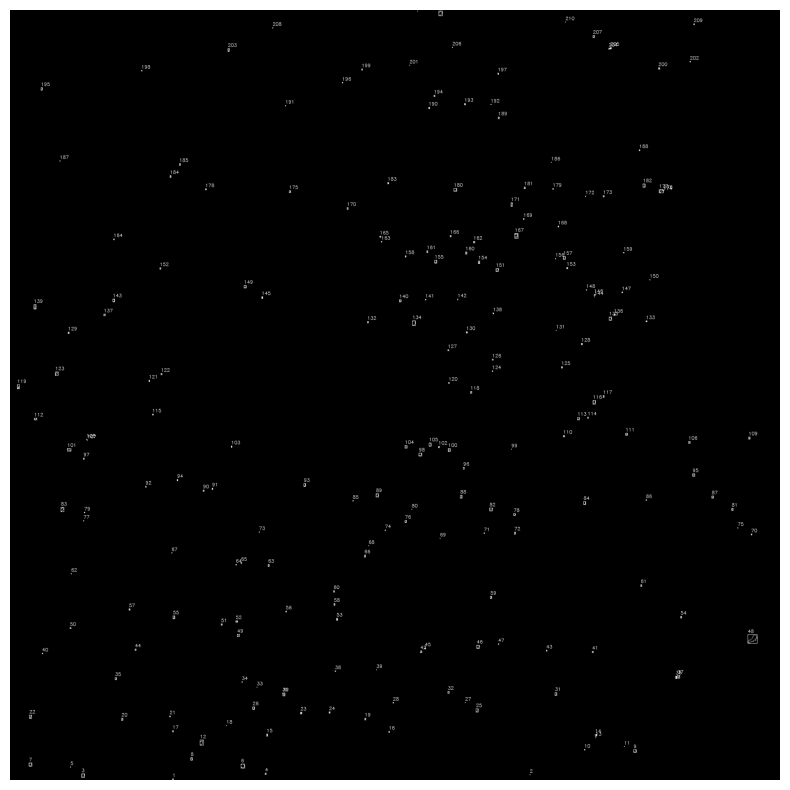

Sample_img
Number of particles: 212
Particle sizes: [1.0, 0.0, 40.5, 3.5, 0.0, 74.5, 43.0, 16.5, 35.0, 1.0, 0.0, 61.5, 0.0, 11.5, 9.0, 1.5, 2.5, 0.0, 6.5, 14.0, 1.5, 25.0, 6.0, 3.5, 31.5, 18.5, 0.0, 1.0, 19.5, 0.0, 19.5, 7.5, 0.0, 0.5, 12.5, 6.5, 18.0, 1.0, 0.0, 1.0, 4.5, 11.0, 2.0, 5.5, 2.0, 38.5, 1.0, 209.5, 16.0, 3.0, 5.0, 6.0, 5.5, 7.0, 21.0, 1.0, 3.5, 6.0, 12.0, 3.5, 7.0, 0.0, 8.5, 1.0, 1.5, 8.0, 0.0, 0.0, 0.0, 1.5, 0.5, 8.0, 0.0, 0.0, 0.0, 13.0, 0.0, 12.5, 1.0, 0.0, 6.0, 33.0, 43.5, 30.0, 0.5, 0.5, 13.5, 23.5, 32.0, 4.0, 3.0, 1.0, 24.0, 2.5, 17.0, 3.5, 2.0, 42.0, 0.0, 22.0, 28.0, 3.5, 2.5, 18.5, 28.5, 12.0, 0.0, 0.0, 14.0, 5.5, 14.0, 16.0, 22.5, 2.5, 2.5, 40.0, 4.5, 9.5, 8.0, 1.0, 2.0, 5.0, 28.5, 0.5, 5.5, 0.5, 3.0, 4.0, 4.0, 4.0, 0.0, 4.5, 3.0, 69.0, 34.5, 3.5, 7.0, 2.0, 40.5, 13.5, 0.5, 0.0, 23.0, 0.0, 5.0, 2.5, 2.0, 0.5, 27.0, 0.0, 26.0, 5.5, 5.0, 12.0, 28.5, 0.0, 24.0, 2.5, 1.0, 12.0, 7.0, 6.5, 1.0, 2.0, 3.0, 5.5, 35.5, 1.5, 2.0, 7.0, 11.5, 0.0, 5.0, 0.0, 10.5, 0.0, 34.5, 3.5

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0.275

binary_mask = (error_map_image > threshold).astype(np.uint8)

contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(error_map_image, dtype=np.uint8)

particle_count = 0
for i, contour in enumerate(contours):
    cv2.drawContours(contour_image, [contour], -1, (255), 1)  # Draw white contours

    # Optionally, draw bounding boxes
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255), 1)

    # Label each particle with a number
    cv2.putText(contour_image, f"{i + 1}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255), 1)

    particle_count += 1

# Plot the results
plt.figure(figsize=(10, 10))
plt.imshow(contour_image, cmap="gray")
plt.axis("off")
plt.show()

particle_sizes = []
for contour in contours:
    area = cv2.contourArea(contour)
    particle_sizes.append(area)

print(f"Sample_img")
print(f"Number of particles: {len(contours)}")
print(f"Particle sizes: {particle_sizes}\n")

In [26]:
with torch.no_grad():
    latent_space = encoder(sample_img)
    #latent_space = autoencoder.module.encoder(sample_img)

print("shape of latent space:", latent_space.shape)
latent_space_flat = latent_space.view(-1, latent_space.shape[1])  # Flatten [B, C, H, W] -> [N, C]
print("Shape of flattened latent space:", latent_space_flat.shape)

shape of latent space: torch.Size([2, 512, 128, 128])
Shape of flattened latent space: torch.Size([32768, 512])


In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  #take the 2 components with that capture the most variance
latent_space_reduced = pca.fit_transform(latent_space_flat.cpu()) #just like the dbscan this expects a 2d representation

#showing that the latent space indeed was reduced
print("Shape of flattened latent space:", latent_space_flat.shape)
print("Shape of reduced latent space:", latent_space_reduced.shape)

Shape of flattened latent space: torch.Size([32768, 512])
Shape of reduced latent space: (32768, 2)


In [28]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

def visualize_pca_with_input(model, dataloader, pca, component=0):
    model.eval()
    with torch.no_grad():
        # Get a sample image and its latent space
        sample_img = next(iter(dataloader))
        sample_img = sample_img.to(device)
        latent_space = model.module.encoder(sample_img)  # Get latent space

        # Flatten the latent space
        latent_space_flat = latent_space.view(-1, latent_space.shape[1])  # [N, C]

        # Apply PCA to the latent space
        latent_space_reduced = pca.transform(latent_space_flat.cpu())  # Reduce to PCA space

        # Select one PCA component and reshape back to spatial dimensions
        latent_activation = latent_space_reduced[:, component].reshape(latent_space.shape[2], latent_space.shape[3])

        # Normalize the activation for better visualization
        latent_activation -= latent_activation.min()
        latent_activation /= latent_activation.max()

        # Resize the activation to match the input size
        resized_activation = resize(torch.tensor(latent_activation).unsqueeze(0), sample_img.shape[-2:])

        # Convert the input image to a CPU numpy array for visualization
        input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()

        # Plot the input and overlay the PCA activation
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(input_img, alpha=0.7)
        plt.imshow(resized_activation.squeeze(), cmap="jet", alpha=0.5)
        plt.title(f"PCA Activation (Component {component})")
        plt.axis("off")
        plt.show()

# Example usage
with torch.no_grad():
    latent_space = autoencoder.module.encoder(next(iter(test_loader)).to(device))
    latent_space_flat = latent_space.view(-1, latent_space.shape[1]).cpu()  # Flatten latent space
    pca = PCA(n_components=2)
    pca.fit(latent_space_flat)  # Fit PCA on latent space

# Visualize PCA activation
visualize_pca_with_input(autoencoder, test_loader, pca, component=0)


ValueError: cannot reshape array of size 32768 into shape (128,128)

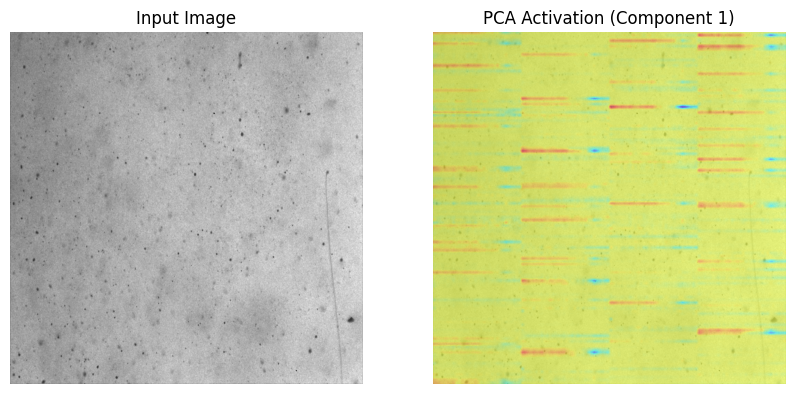

In [43]:
visualize_pca_with_input(autoencoder, test_loader, pca, component=1)

In [29]:
from sklearn.cluster import DBSCAN

# Step 1: Define DBSCAN parameters
eps = 0.5  # Distance threshold for clustering
min_samples = 2  # Minimum points to form a dense region

# Step 2: Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(latent_space_flat.cpu())

# Step 3: Analyze the output
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # Exclude noise
num_noise = list(cluster_labels).count(-1)

print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise}")

Number of clusters found: 130
Number of noise points: 22935


In [73]:
from collections import Counter
import numpy as np

# Count occurrences of each cluster label
cluster_counts = Counter(cluster_labels)

# Optional: Convert counts to a NumPy array for further analysis
counts_array = np.array(list(cluster_counts.items()))  # Format: [[cluster_label, count], ...]

In [68]:
print(sum(counts_array[2:, 1]))

189


In [69]:
total_points = counts_array[2:, 1].sum()
print(f"Total Points: {total_points}")

Total Points: 189


In [33]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize
import numpy as np

def visualize_dbscan_with_input(model, dataloader, dbscan_labels):
    model.eval()
    with torch.no_grad():
        # Get a sample image and its latent space
        sample_img = next(iter(dataloader))
        sample_img = sample_img.to(device)
        latent_space = model.module.encoder(sample_img)  # Get latent space

        # Flatten the latent space for clustering
        latent_space_flat = latent_space.view(-1, latent_space.shape[1])  # [N, C]

        # Reshape DBSCAN labels back to the spatial dimensions THIS IS FOR BATCH SIZE 1
        #cluster_map = np.array(dbscan_labels).reshape(latent_space.shape[2], latent_space.shape[3])  # [H, W]
        # Reshape for each image in the batch
        cluster_maps = []
        for i in range(latent_space.shape[0]):  # Iterate over the batch
            start_idx = i * latent_space.shape[2] * latent_space.shape[3]
            end_idx = start_idx + latent_space.shape[2] * latent_space.shape[3]
            cluster_map = np.array(dbscan_labels[start_idx:end_idx]).reshape(latent_space.shape[2], latent_space.shape[3])
            cluster_maps.append(cluster_map)

        # Normalize the cluster map for visualization
        cluster_map = cluster_map.astype(float)  # Convert to float for heatmap
        cluster_map[cluster_map == -1] = np.nan  # Set noise points to NaN for transparency

        # Resize the cluster map to match the input size
        resized_cluster_map = resize(torch.tensor(cluster_map).unsqueeze(0), sample_img.shape[-2:])


        # Convert the input image to a CPU numpy array for visualization
        input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()

        # Plot the input and overlay the DBSCAN results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(input_img, alpha=0.7)
        plt.imshow(resized_cluster_map.squeeze(), cmap="tab20", alpha=0.5)  # Use tab20 for distinct clusters
        plt.title("DBSCAN Clustering")
        plt.axis("off")

        plt.show()

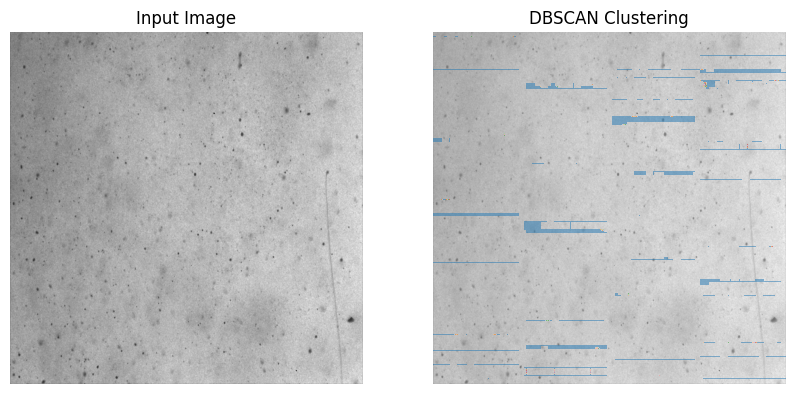

In [50]:
dbscan = DBSCAN(eps=0.5, min_samples=2) #Eps is max distance between points & min_samples to be considered a particle

latent_space_flat = latent_space.view(-1, latent_space.shape[1]).cpu() #dbscan expects 2d data so flatten the 4d latent space

dbscan_labels = dbscan.fit_predict(latent_space_flat) #run dbscan to assign cluster labels if -1 it is noise else cluster

visualize_dbscan_with_input(autoencoder, test_loader, dbscan_labels) #show results

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize the data
scaler = StandardScaler()
latent_space_normalized = scaler.fit_transform(latent_space_flat.cpu().numpy())  # Move tensor to CPU before converting to NumPy

# Step 2: Apply PCA to reduce to 2D or 3D for clustering and visualization
pca = PCA(n_components=2)  # Reduce to 2D for visualization
latent_space_reduced = pca.fit_transform(latent_space_normalized)

print("Shape of reduced latent space:", latent_space_reduced.shape)

Shape of reduced latent space: (32768, 2)


In [94]:
#Implement the same way as we did the first dbscan
dbscan_pca = DBSCAN(eps=0.75, min_samples=5)
cluster_labels_pca = dbscan.fit_predict(latent_space_reduced)

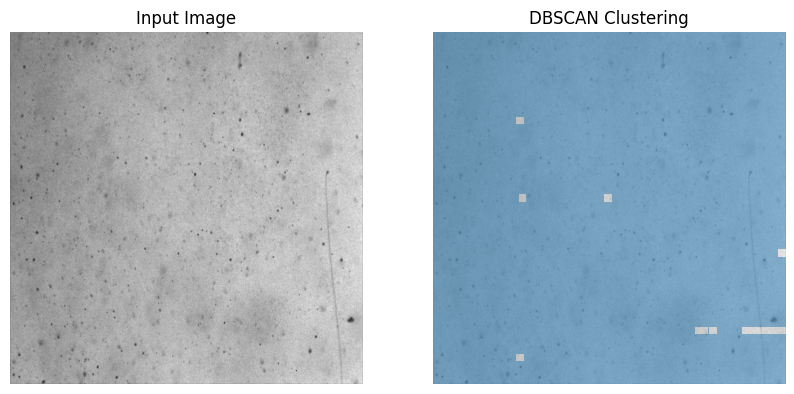

In [37]:
visualize_dbscan_with_input(autoencoder, test_loader, cluster_labels_pca)

In [76]:
def visualize_clusters_with_input(cluster_labels, latent_shape, original_image, original_shape, image_index=0):
    """
    Visualize DBSCAN clusters for a single image alongside its original image.

    Parameters:
    - cluster_labels: Cluster labels from DBSCAN (flattened, 1D array, includes all batch images)
    - latent_shape: Tuple (H, W) of the latent space dimensions
    - original_image: Original input image (H, W, C) as a numpy array or tensor
    - original_shape: Tuple (H, W) of the original image dimensions
    - image_index: Index of the image in the batch to visualize (default: 0)

    Returns:
    - clustered_image_resized: Cluster visualization resized to original dimensions for the selected image
    """
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract latent space dimensions
    H, W = latent_shape
    original_height, original_width = original_shape

    # Number of labels per image
    labels_per_image = H * W

    # Extract cluster labels for the specified image
    start_idx = image_index * labels_per_image
    end_idx = start_idx + labels_per_image
    cluster_labels_reshaped = np.array(cluster_labels[start_idx:end_idx]).reshape(H, W)

    # Resize cluster visualization to match original image dimensions
    clustered_image_resized = cv2.resize(
        cluster_labels_reshaped, 
        (original_width, original_height), 
        interpolation=cv2.INTER_NEAREST
    )

    # Convert original image to a NumPy array if it's a tensor
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.cpu().permute(1, 2, 0).numpy()

    # Ensure proper aspect ratio and scaling in the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figure size for side-by-side
    # Plot the original image
    axes[0].imshow(original_image, cmap="gray", aspect="auto")
    axes[0].set_title(f"Original Image - Image {image_index + 1}")
    axes[0].axis("off")

    # Plot the clustered image
    im = axes[1].imshow(clustered_image_resized, cmap="viridis", aspect="auto")
    axes[1].set_title(f"Cluster Visualization - Image {image_index + 1}")
    axes[1].axis("off")

    # Add colorbar
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # Enforce equal scaling
    plt.subplots_adjust(wspace=0.05)  # Adjust spacing to ensure alignment
    plt.show()

    return clustered_image_resized

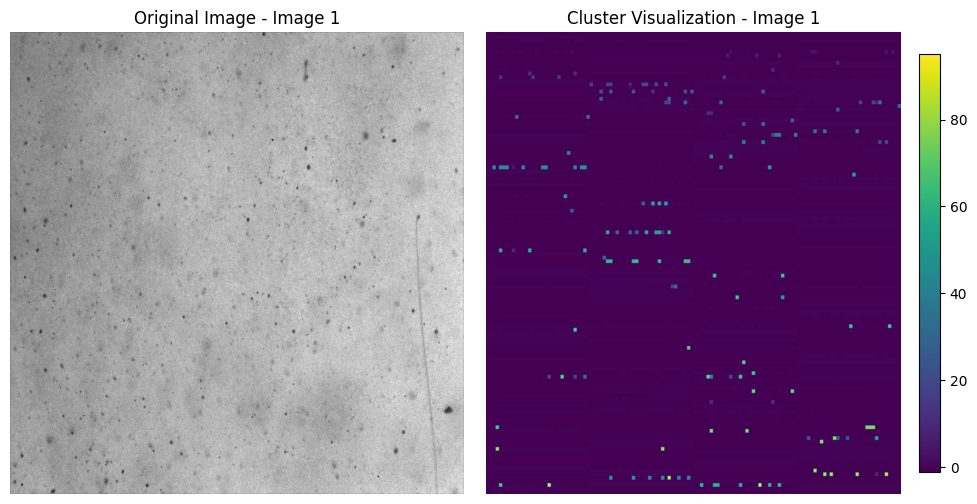

In [78]:
latent_shape = (128, 128)
original_shape = (2048, 2048)
original_image = sample_img[0]  # Assuming test_images[0] is the original input image as a tensor or array

# Visualize clusters with the original image for the first image in the batch
clustered_image = visualize_clusters_with_input(dbscan_labels, latent_shape, original_image, original_shape, image_index=0)

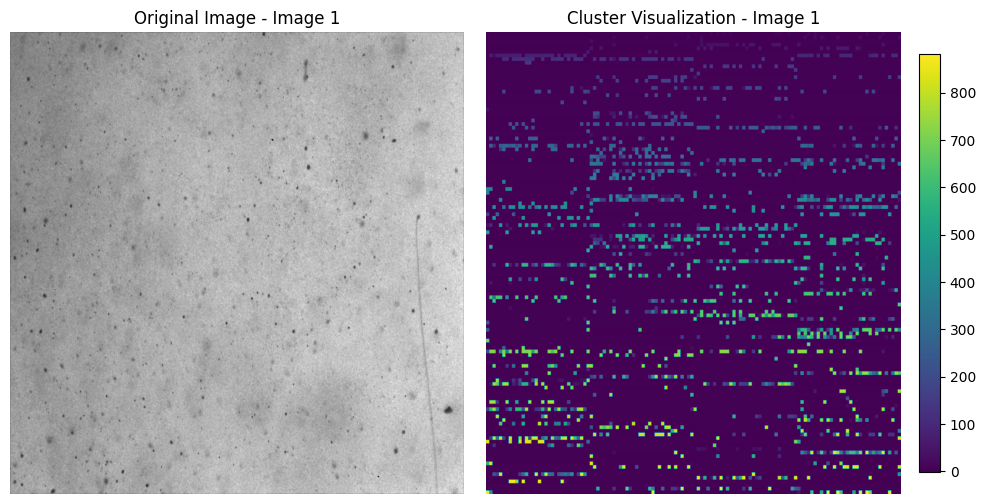

In [93]:
clustered_image = visualize_clusters_with_input(cluster_labels_pca, latent_shape, original_image, original_shape, image_index=0)

In [75]:
#trying to add coordinates 

h, w = latent_space.shape[2], latent_space.shape[3]  # h=128, w=128
grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h), indexing='xy')  # Shape: [128, 128]

In [76]:
spatial_features = np.stack([grid_x, grid_y], axis=-1).reshape(-1, 2)  # Shape: [16384, 2]

In [78]:
augmented_features = np.hstack([latent_space_flat.cpu(), spatial_features])  # Shape: [16384, 514]

In [79]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.0, min_samples=5)  # Adjust these parameters
dbscan_labels = dbscan.fit_predict(augmented_features)  # Shape: [16384]

In [80]:
cluster_map = dbscan_labels.reshape(h, w)  # Shape: [128, 128]

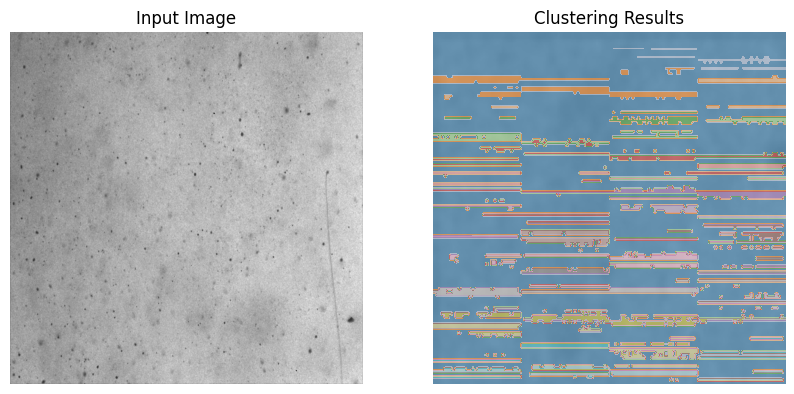

In [81]:
# Convert the input image to a CPU numpy array
input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()  # Shape: [H, W, C]

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(input_img, alpha=0.7)
plt.imshow(cluster_map, cmap='tab20', alpha=0.5)  # Use 'tab20' for distinct clusters
plt.title("Clustering Results")
plt.axis("off")
plt.show()

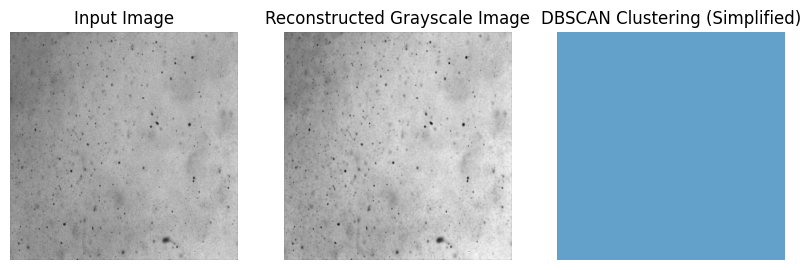

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from torchvision.transforms.functional import resize

# Function to cluster simplified autoencoder output
def cluster_simplified_output(autoencoder, dataloader, eps=2.0, min_samples=5, downsample_size=(128, 128)):
    autoencoder.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Get a sample image from the dataloader
        sample_img = next(iter(dataloader))
        sample_img = sample_img.to(device)  # Move to GPU if available

        # Forward pass to get the reconstructed output
        reconstructed_img = autoencoder(sample_img)
        reconstructed_img = reconstructed_img[0].cpu().permute(1, 2, 0).numpy()  # First image in batch

        # Convert to grayscale for simplicity
        reconstructed_gray = np.mean(reconstructed_img, axis=-1)  # Shape: [H, W]

        # Downsample the grayscale image
        downsampled_gray = resize(torch.tensor(reconstructed_gray).unsqueeze(0), downsample_size).squeeze().numpy()

        # Flatten the downsampled image for clustering
        h, w = downsampled_gray.shape  # Downsampled height and width
        flattened_output = downsampled_gray.flatten().reshape(-1, 1)  # Shape: [H*W, 1]

        # Apply DBSCAN on the flattened output
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(flattened_output)  # Shape: [H*W]

        # Reshape the labels back to the downsampled image dimensions
        cluster_map = labels.reshape(h, w)

        # Visualize the clustering result
        plt.figure(figsize=(10, 5))

        # Original input image
        plt.subplot(1, 3, 1)
        input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()
        input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())  # Normalize
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        # Grayscale reconstructed image
        plt.subplot(1, 3, 2)
        plt.imshow(reconstructed_gray, cmap="gray")
        plt.title("Reconstructed Grayscale Image")
        plt.axis("off")

        # Clustering result
        plt.subplot(1, 3, 3)
        plt.imshow(cluster_map, cmap='tab20', alpha=0.7)  # Use a colormap for distinct clusters
        plt.title("DBSCAN Clustering (Simplified)")
        plt.axis("off")

        plt.show()

# Example usage
cluster_simplified_output(autoencoder, test_loader, eps=2.0, min_samples=5, downsample_size=(128, 128))

In [24]:
def cluster_simplified_output(autoencoder, dataloader, eps=2.0, min_samples=5, downsample_size=(128, 128)):
    autoencoder.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Get a sample image from the dataloader
        sample_img = next(iter(dataloader))
        sample_img = sample_img.to(device)  # Move to GPU if available

        # Forward pass to get the reconstructed output
        reconstructed_img = autoencoder(sample_img)
        reconstructed_img = reconstructed_img[0].cpu().permute(1, 2, 0).numpy()  # First image in batch

        # Convert to grayscale for simplicity
        reconstructed_gray = np.mean(reconstructed_img, axis=-1)  # Shape: [H, W]

        # Downsample the grayscale image
        downsampled_gray = resize(torch.tensor(reconstructed_gray).unsqueeze(0), downsample_size).squeeze().numpy()

        # Normalize for better clustering
        downsampled_gray = (downsampled_gray - downsampled_gray.min()) / (downsampled_gray.max() - downsampled_gray.min())

        # Flatten the downsampled image for clustering
        h, w = downsampled_gray.shape  # Downsampled height and width
        flattened_output = downsampled_gray.flatten().reshape(-1, 1)  # Shape: [H*W, 1]

        # Apply DBSCAN on the flattened output
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(flattened_output)  # Shape: [H*W]

        # Reshape the labels back to the downsampled image dimensions
        cluster_map = labels.reshape(h, w)

        # Debugging: Print unique labels
        unique_labels = np.unique(cluster_map)
        print(f"Unique labels: {unique_labels}")

        # Visualize the clustering result
        plt.figure(figsize=(10, 5))

        # Original input image
        plt.subplot(1, 3, 1)
        input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()
        input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())  # Normalize
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        # Grayscale reconstructed image
        plt.subplot(1, 3, 2)
        plt.imshow(reconstructed_gray, cmap="gray")
        plt.title("Reconstructed Grayscale Image")
        plt.axis("off")

        # Clustering result
        plt.subplot(1, 3, 3)
        plt.imshow(cluster_map, cmap='tab20', alpha=0.7)  # Use a colormap for distinct clusters
        plt.title("DBSCAN Clustering (Simplified)")
        plt.colorbar(label="Cluster Label")
        plt.axis("off")

        plt.show()

Unique labels: [0]


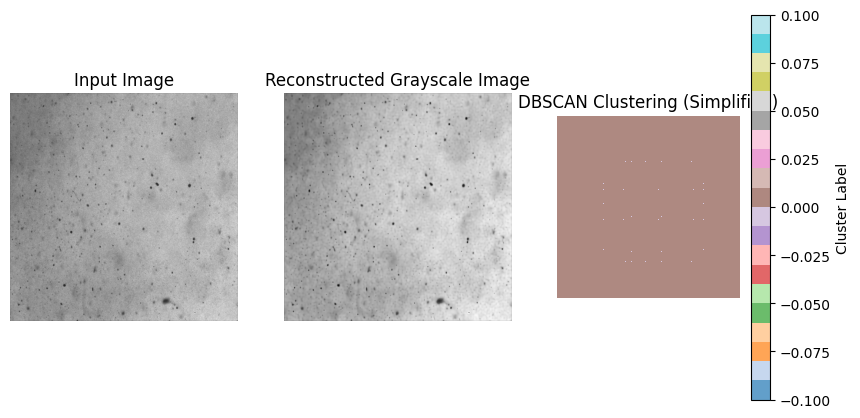

In [28]:
cluster_simplified_output(autoencoder, test_loader, eps=0.1, min_samples=3, downsample_size=(128, 128))

In [ ]:
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # 16x16 -> 32x32
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # 64x64 -> 128x128
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # 128x128 -> 256x256
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # 256x256 -> 512x512
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # 512x512 -> 1024x1024
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Final layer: 1024x1024 -> Output
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Normalize output to range [0, 1]
        )

    def forward(self, x):
        return self.decoder(x)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
